In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sunpy 
import sunpy.map
from sunpy.coordinates import Helioprojective, propagate_with_solar_surface
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import eispac
from astropy.visualization import ImageNormalize, AsinhStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from sun_blinker import SunBlinker


In [2]:
eis_pointing_save = np.load('../../src/EIS/eis_pointing/eis_20221024_193612/pointing_verification/20221024_193612/offsets.npz',allow_pickle=True)

In [3]:
eis_pointing_x = eis_pointing_save['x']
eis_pointing_y = eis_pointing_save['y']

In [4]:
eis_195_fitres = eispac.read_fit("../../src/EIS/HH_Flare/20221024T1808/fitres/eis_20221024_193612.fe_12_195_119.1c-0.fit.h5")
eis_195_intmap = eis_195_fitres.get_map()
eis_195_velmap = eis_195_fitres.get_map(measurement='velocity')

Reading fit result from, 
   ../../src/EIS/HH_Flare/20221024T1808/fitres/eis_20221024_193612.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


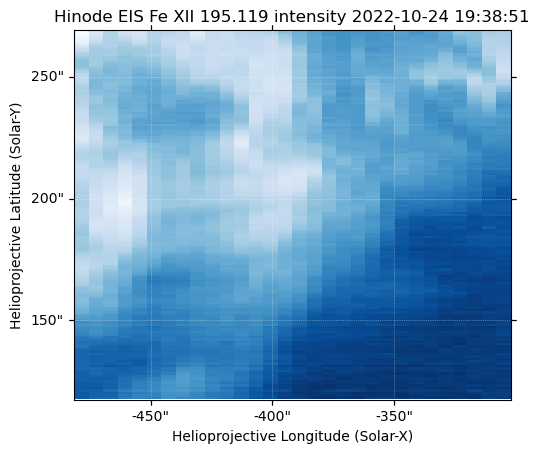

In [5]:
eis_195_intmap.plot()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


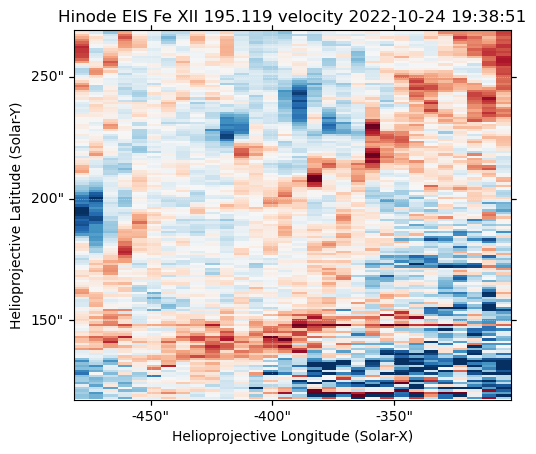

In [6]:
eis_195_velmap.plot()

In [7]:
def solar_rotation_compensate_xy_interp(x, y, date_start, date_end, date_average):
    nx = x.shape[1]
    ny = y.shape[0]

    x_derot = np.zeros_like(x)
    y_derot = np.zeros_like(y)

    # EIS scans from west to east
    date_grid = np.linspace(date_end, date_start, nx)

    unify_helioprojective_frame = Helioprojective(observer='earth', obstime=date_average,rsun=696000000.0*u.m)


    for ii in range(nx):
        helioprojective_frame_ii = Helioprojective(observer='earth', obstime=date_grid[ii],rsun=696000000.0*u.m)
        coords_ii = SkyCoord(x[:,ii]*u.arcsec, y[:,ii]*u.arcsec, frame=helioprojective_frame_ii)
        with propagate_with_solar_surface(rotation_model='rigid'):
            coords_ii_unified = coords_ii.transform_to(unify_helioprojective_frame)
        x_derot[:,ii] = coords_ii_unified.Tx.to_value(u.arcsec)
        y_derot[:,ii] = coords_ii_unified.Ty.to_value(u.arcsec)
    
    x_interp = np.linspace(x_derot.min(), x_derot.max(), nx)
    y_interp = np.linspace(y_derot.min(), y_derot.max(), ny)

    return x_derot, y_derot, x_interp, y_interp    

In [8]:
def xy_to_wcs(x,y,data,date_obs,instrument,observatory):
    nx = data.shape[1]
    ny = data.shape[0]
    wcs_header = sunpy.map.make_fitswcs_header(data,
                                               coordinate=SkyCoord(x[nx//2], y[ny//2], unit=u.arcsec,
                                                                             frame="helioprojective", obstime=date_obs,
                                                                             rsun=696000000.0*u.m),
                                                reference_pixel=[nx//2, ny//2]*u.pix,
                                            scale=[np.abs(x[-1] - x[0])/(nx - 1), np.abs(y[-1] - y[0])/(ny - 1)] * u.arcsec/u.pix,
                                            instrument=instrument,
                                            observatory=observatory,
                                            ) 
    return WCS(wcs_header)                                                  
    


In [9]:
eis_pointing_x_derot, eis_pointing_y_derot, x_interp_derot, y_interp_derot = \
    solar_rotation_compensate_xy_interp(eis_pointing_x, eis_pointing_y, eis_195_intmap.date_start, eis_195_intmap.date_end, eis_195_intmap.date_average)

In [10]:
xi_interp_derot = np.moveaxis(np.array(np.meshgrid(x_interp_derot, y_interp_derot)), 0, -1)
points_derot = (eis_pointing_x_derot.flatten(), eis_pointing_y_derot.flatten())

eis_int_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_intmap.data.flatten())
eis_int_interp_linear_derot = eis_int_interp_linear_func_derot(xi_interp_derot)

eis_vel_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_velmap.data.flatten())
eis_vel_interp_linear_derot = eis_vel_interp_linear_func_derot(xi_interp_derot)

In [11]:
eis_interp_wcs_derot = xy_to_wcs(x_interp_derot, y_interp_derot, eis_int_interp_linear_derot, eis_195_intmap.date_average, 'EIS', 'Hinode')

In [12]:
eis_195_int_interp_linear_map_derot = sunpy.map.Map(eis_int_interp_linear_derot, eis_interp_wcs_derot)
eis_195_int_interp_linear_map_derot.plot_settings["aspect"] = eis_195_int_interp_linear_map_derot.scale.axis2/eis_195_int_interp_linear_map_derot.scale.axis1
eis_195_int_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch())
eis_195_int_interp_linear_map_derot.plot_settings["cmap"] = 'sdoaia193'

eis_195_vel_interp_linear_map_derot = sunpy.map.Map(eis_vel_interp_linear_derot, eis_interp_wcs_derot)
eis_195_vel_interp_linear_map_derot.plot_settings["aspect"] = eis_195_vel_interp_linear_map_derot.scale.axis2/eis_195_vel_interp_linear_map_derot.scale.axis1
eis_195_vel_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(vmin=-15,vmax=15)
eis_195_vel_interp_linear_map_derot.plot_settings["cmap"] = 'RdBu_r'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


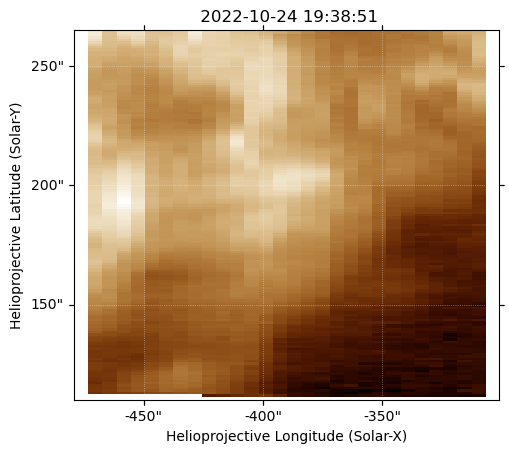

In [13]:
eis_195_int_interp_linear_map_derot.plot()

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


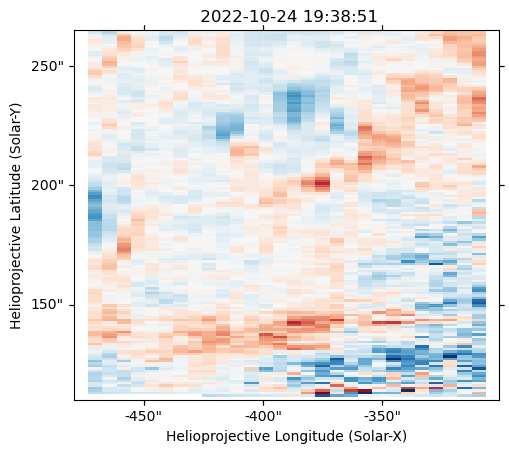

In [14]:
eis_195_vel_interp_linear_map_derot.plot()

In [17]:
def aia_prep(aia_map):
    map_updated_pointing = update_pointing(aia_map)
    map_registered = register(map_updated_pointing)

    return map_registered

In [18]:
aia_193_1938 = sunpy.map.Map('../../src/EIS/eis_pointing/sdo/aia/level1/2022/10/24/aia.lev1.193A_2022-10-24T19-38-28.image_lev1.fits')
aia_193_1938 = aia_prep(aia_193_1938)

In [19]:
SunBlinker(eis_195_int_interp_linear_map_derot, aia_193_1938, reproject=True)

In [15]:
eis_195_int_interp_linear_map_derot.save("../../src/coalign_map/20221024/eis_hhflare_195_intmap_shift.fits",overwrite=True)
eis_195_vel_interp_linear_map_derot.save("../../src/coalign_map/20221024/eis_hhflare_195_velmap_shift.fits",overwrite=True)